In [1]:
import os
from fnmatch import fnmatch

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio

from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0 = 70, Om0 = 0.3, Ode0 = 0.7)

plt.rcParams.update({
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

import treecorr

KiDS-1000 tomographic binning: <br>
| Bin |    $z_{\rm B}$ range     |       $m$        |
|-----|:------------------------:|:----------------:|
|  1  |$0.1 < z_{\rm B} \leq 0.3$|$-0.009 \pm 0.019$|
|  2  |$0.3 < z_{\rm B} \leq 0.5$|$-0.011 \pm 0.020$|
|  3  |$0.5 < z_{\rm B} \leq 0.7$|$-0.015 \pm 0.017$|
|  4  |$0.7 < z_{\rm B} \leq 0.9$|$ 0.002 \pm 0.012$|
|  5  |$0.9 < z_{\rm B} \leq 1.2$|$ 0.007 \pm 0.010$|<br>

Drawn from Giblin et al. (2020)


In [2]:
bin1_data = fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin1.fits', ext = 1)
bin1_data = Table(bin1_data)

# bin2_data = fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin2.fits', ext = 1)
# bin2_data = Table(bin2_data)

# bin3_data = fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin3.fits', ext = 1)
# bin3_data = Table(bin3_data)

# bin4_data = fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin4.fits', ext = 1)
# bin4_data = Table(bin4_data)

# bin5_data = fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin5.fits', ext = 1)
# bin5_data = Table(bin5_data)

In [3]:
n_z_bin1 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO1_Nz.asc')
# n_z_bin2 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO2_Nz.asc') 
# n_z_bin3 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO3_Nz.asc') 
# n_z_bin4 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO4_Nz.asc') 
# n_z_bin5 = ascii.read('/data2/lsajkov/mpdg/data/KiDS/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO5_Nz.asc') 

In [4]:
n_z_mean_bin1 = np.dot(n_z_bin1['col1'], n_z_bin1['col2'])

In [5]:
def degree_to_hMpc(degree, redshift):
    radian = (degree * u.degree).to(u.radian)
    comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    hMpc = comoving_dist_Mpc * np.tan(radian)
    return hMpc

def hMpc_to_degree(hMpc, redshift):
    comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    radian = np.arctan(hMpc/comoving_dist_Mpc)
    degree = (radian * u.radian).to(u.degree)
    return degree.value

Attempt to measure signal in tomographic bin 1, higher mass dwarfs

In [12]:
sources_bin1 = treecorr.Catalog(ra = bin1_data['RAJ2000'], dec = bin1_data['DECJ2000'],
                                g1 = bin1_data['e1'], g2 = bin1_data['e2'],
                                w = bin1_data['weight'],
                                ra_units = 'degrees', dec_units = 'degrees')

In [7]:
lens_cat = treecorr.Catalog('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_mstar_md_bin_31Jul24.fits',
                              ra_col = 'ra', dec_col = 'dec',
                              ra_units = 'degrees', dec_units = 'degrees')
                            #   w = 'weight')

In [15]:
log10_hMpc_bin_lo = -2
log10_hMpc_bin_hi = 2
bins = 30
hMpc_bins = np.logspace(log10_hMpc_bin_lo, log10_hMpc_bin_hi, bins)

degree_bins = hMpc_to_degree(hMpc_bins, n_z_mean_bin1)

In [16]:
config = {'nbins':   bins,
          'min_sep': degree_bins[0],
          'max_sep': degree_bins[1],
          'sep_units': 'degree'}

In [17]:
ngc = treecorr.NGCorrelation(config = config)

In [18]:
ngc.process(lens_cat, sources_bin1)

Text(0, 0.5, '$\\langle \\gamma_T \\rangle$')

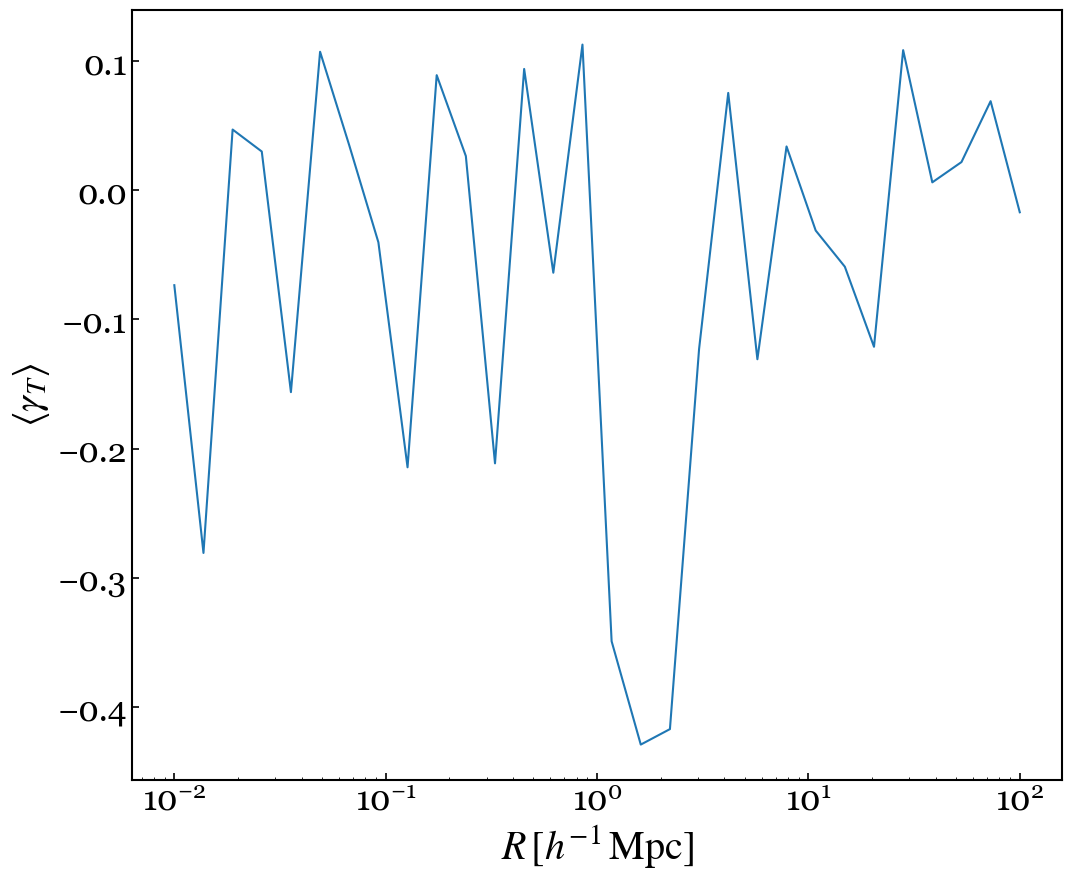

In [19]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.plot(hMpc_bins, ngc.xi)
ax.set_xscale('log')
ax.set_xlabel(r'$R\, [h^{-1} {\rm\, Mpc}]$')
ax.set_ylabel(r'$\langle \gamma_T \rangle$')